In [2]:
import os, socket
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
import numpy as np
import pandas as pd
import h5py
from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision.io import read_image
import torchvision.transforms as transforms
from einops import rearrange

from util.frame_triplet_loader import Frameloader
from util.transforms import RandomApplyTransform, RandomShiftsAug, GaussianNoise
from util.util import load_checkpoint, get_args_parser
from reward_model import Model


hostname = socket.gethostname()
if hostname == 'beehive.ttic.edu':
   data_path = '/share/data/ripl/rank2reward/'
   output_path = '/home-nfs/kevinwu/ripl/Video2Reward/output'
if hostname == 'maple':
   data_path='/home/kevinwu/ripl/Video2Reward/data/rank2reward/'
   output_path='/home/kevinwu/ripl/Video2Reward/output/'

tasks = [
   'assembly', 'drawer-open', 'hammer', 'door-close', 'push',
   'reach', 'button-press-topdown', 'door-open'
]

args = get_args_parser()
args.data_path = data_path
args.output_dir = output_path
args.normalize_prediction = True
args.augment = True
args.randomize = True
args.batch_size = 16
args.num_workers = 8
args.resume = 'last'
if args.normalize_prediction:
    args.output_dir += '_norm'
if args.randomize:
    args.output_dir += '_rand'
if args.augment:
    args.output_dir += '_aug'
args.output_dir += '/'

In [67]:
if not args.augment:
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
else:
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        RandomApplyTransform([
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            GaussianNoise(mean=0, std=(0.01, 0.1)),
            RandomShiftsAug(pad=4)
        ]),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
dataset_eval = Frameloader(root_dir=args.data_path, 
                           test=False,
                           transforms=transform, 
                           normalize_trajectory=args.normalize_prediction,
                           subset_len=1,
                           randomized=args.randomize)

data_loader_eval = DataLoader(
            dataset_eval,
            batch_size=args.batch_size,
            num_workers=args.num_workers,
            shuffle=False,
            drop_last=False,
            persistent_workers = True)


model = Model(model_type='resnet18')
device_id = torch.cuda.current_device()
print('GPU Device ID:', device_id)
model.to(device_id)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

model, optimizer, epoch = load_checkpoint(args.output_dir, model, optimizer, args.resume)

GPU Device ID: 0


In [68]:
with torch.no_grad():
    model.eval()
    for cur_batch, cur_lbl, delta in data_loader_eval:
        cur_batch = cur_batch.to(device_id)
        cur_batch = rearrange(cur_batch, 'b i c h w -> (b i) c h w')

        # Ground truth
        true_mean = rearrange(cur_lbl, 'b i -> (b i)').numpy()
        delta = delta.squeeze().numpy()
        true_std = 1 / delta

        # Prediction
        pred_dist = model(cur_batch)
        pred_mean = pred_dist.loc.squeeze().cpu().numpy()
        pred_std = pred_dist.scale.squeeze().cpu().numpy()

        df = pd.DataFrame({
            'true_mean': true_mean,
            'pred_mean': pred_mean,
            'true_std': true_std,
            'pred_std': pred_std,
            'delta': delta
        })
        print(df.round(3).to_string(index=False))
        break

 true_mean  pred_mean  true_std  pred_std  delta
     0.000      0.129     0.045     0.064     22
     0.769      0.794     0.077     0.065     13
     0.667      0.671     0.167     0.614      6
     0.125      0.107     0.062     0.107     16
     0.375      0.394     0.062     0.077     16
     0.556      0.681     0.111     0.146      9
     0.500      0.507     0.036     0.054     28
     0.667      0.533     0.111     0.190      9
     0.237      0.236     0.017     0.032     59
     0.870      0.856     0.014     0.030     69
     0.053      0.052     0.013     0.022     75
     0.733      0.714     0.033     0.041     30
     0.348      0.332     0.043     0.068     23
     0.750      0.886     0.042     0.104     24
     1.000      0.716     1.000     1.009      1
     0.769      0.806     0.019     0.061     52


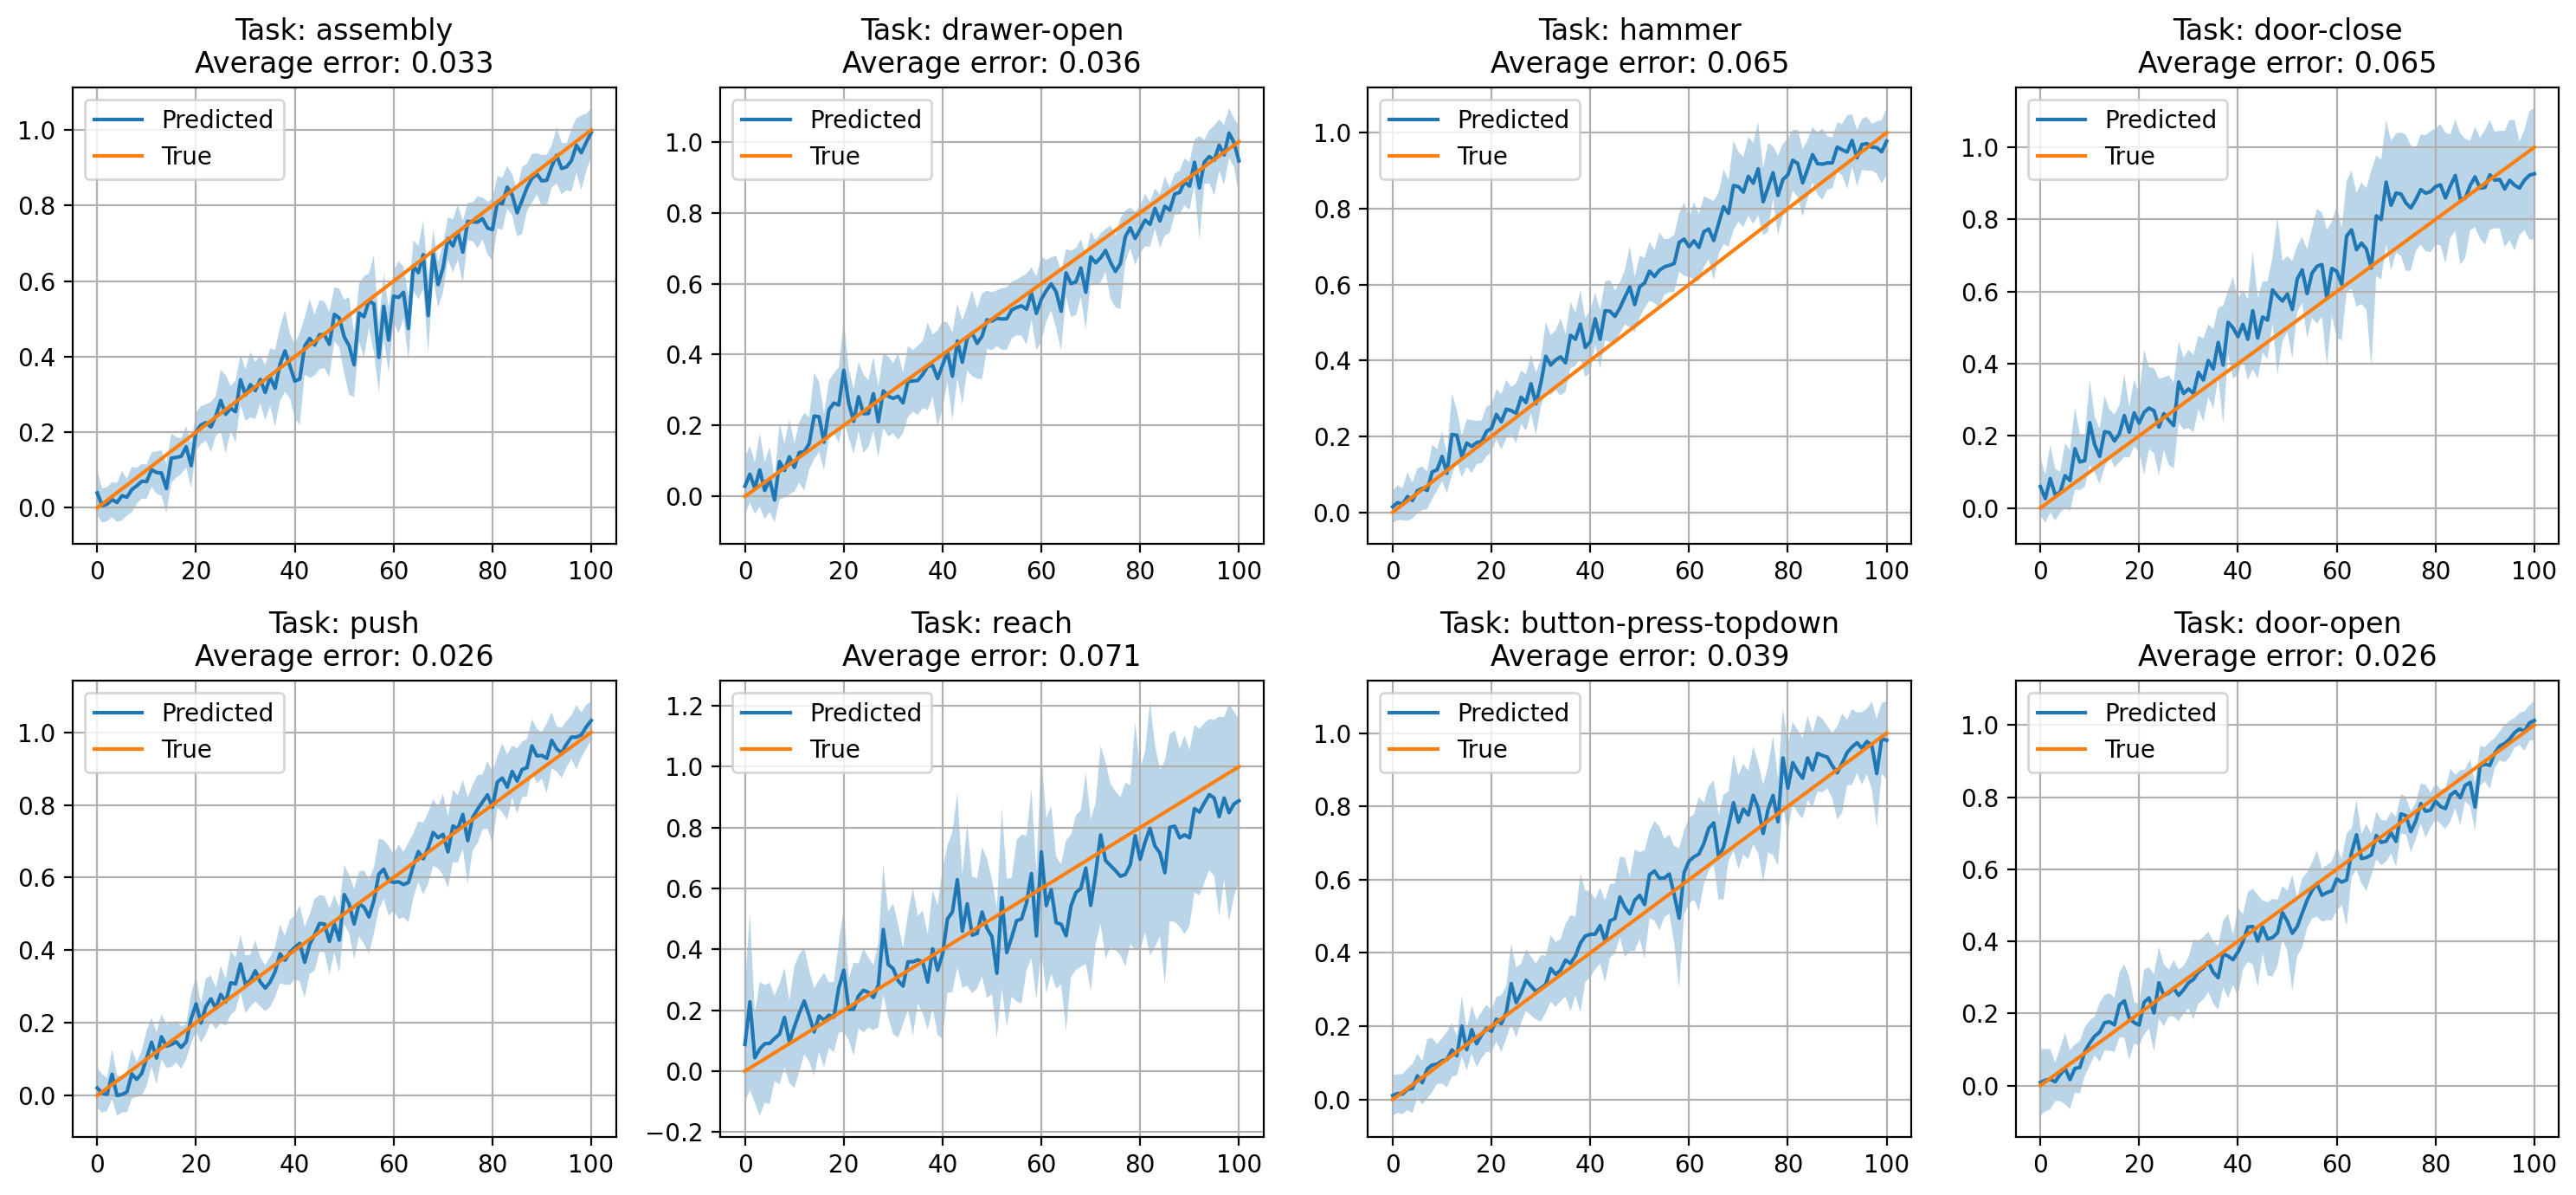

In [69]:
def show_entire_trajectory(task, ax):
    # Set start frame as 0, goal frame as 100
    init_frame = os.path.join(data_path, task, 'test', '0', '0.png')
    goal_frame = os.path.join(data_path, task, 'test', '2', '100.png')

    # Load the entire trajectory
    all_frames = []
    for i in range(101):
        mid_frame = os.path.join(data_path, task, 'test', '0', f'{i}.png')
        cur = torch.vstack(
                (transform(read_image(init_frame)),
                 transform(read_image(mid_frame)),
                 transform(read_image(goal_frame))))
        all_frames.append(cur)
    cur_batch = torch.stack(all_frames, axis=0).to(device_id)
    true_mean = np.arange(0, 1.01, 0.01)

    # Prediction
    pred_dist = model(cur_batch)
    pred_mean = pred_dist.loc.squeeze().cpu().detach().numpy()
    pred_std = pred_dist.scale.squeeze().cpu().detach().numpy()

    # Plot
    avg_error = np.mean(np.abs(pred_mean - true_mean))
    ax.set_title(f'Task: {task}\nAverage error: {avg_error:.3f}')
    ax.plot(pred_mean, label='Predicted')
    ax.fill_between(range(len(pred_mean)), pred_mean - 2*pred_std, pred_mean + 2*pred_std, alpha=0.3)
    ax.plot(true_mean, label='True')
    ax.legend()
    ax.grid()

# Plot all tasks
fig, axs = plt.subplots(2, 4, figsize=(15, 7))
for i, task in enumerate(tasks):
    ax = axs[i // 4, i % 4]
    show_entire_trajectory(task, ax=ax)
plt.tight_layout()
# plt.savefig(args.output_dir + 'all_tasks.png')
plt.show()

In [70]:
def pred_and_show(task, transform, init, mid, goal):
    # Load the images
    init_frame = os.path.join(data_path, task, 'test', '0', f'{init}.png')
    mid_frame = os.path.join(data_path, task, 'test', '0', f'{mid}.png')
    goal_frame = os.path.join(data_path, task, 'test', '0', f'{goal}.png')
    init_img = transform(read_image(init_frame))
    mid_img = transform(read_image(mid_frame))
    goal_img = transform(read_image(goal_frame))
    cur = torch.vstack((init_img, mid_img, goal_img))
    
    # Predict the reward
    cur_batch = cur.unsqueeze(0).to(device_id)
    delta = goal - init
    lbl = mid - init
    if args.normalize_prediction:
        lbl /= delta
    pred_dist = model(cur_batch)
    pred_mean = pred_dist.loc.squeeze().cpu().detach().numpy()
    pred_std = pred_dist.scale.squeeze().cpu().detach().numpy()
    pred_str = f'Predicted (mean, std) = ({pred_mean:.3f}, {pred_std:.3f})\n' + \
               f'True (mean, std) = ({lbl:.3f}, {1/delta:.3f})'

    # Display the images
    inv_normalize = transforms.Normalize(
        mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
        std=[1/0.5, 1/0.5, 1/0.5]
    )
    inv_transform = transforms.Compose([
        inv_normalize,
        transforms.ToPILImage()
    ])
    init_img_pil = inv_transform(init_img)
    mid_img_pil = inv_transform(mid_img)
    goal_img_pil = inv_transform(goal_img)
    _, axs = plt.subplots(1, 3, figsize=(11, 5.5))
    axs[0].imshow(init_img_pil)
    axs[0].set_title(f'Initial Frame: {init}')
    axs[1].imshow(mid_img_pil)
    axs[1].set_title(f'Middle Frame: {mid}\n' + pred_str)
    axs[2].imshow(goal_img_pil)
    axs[2].set_title(f'Goal Frame: {goal}')
    for ax in axs:
        ax.axis('off')
    plt.suptitle(f'Task: {task}', fontsize=20)
    plt.tight_layout()

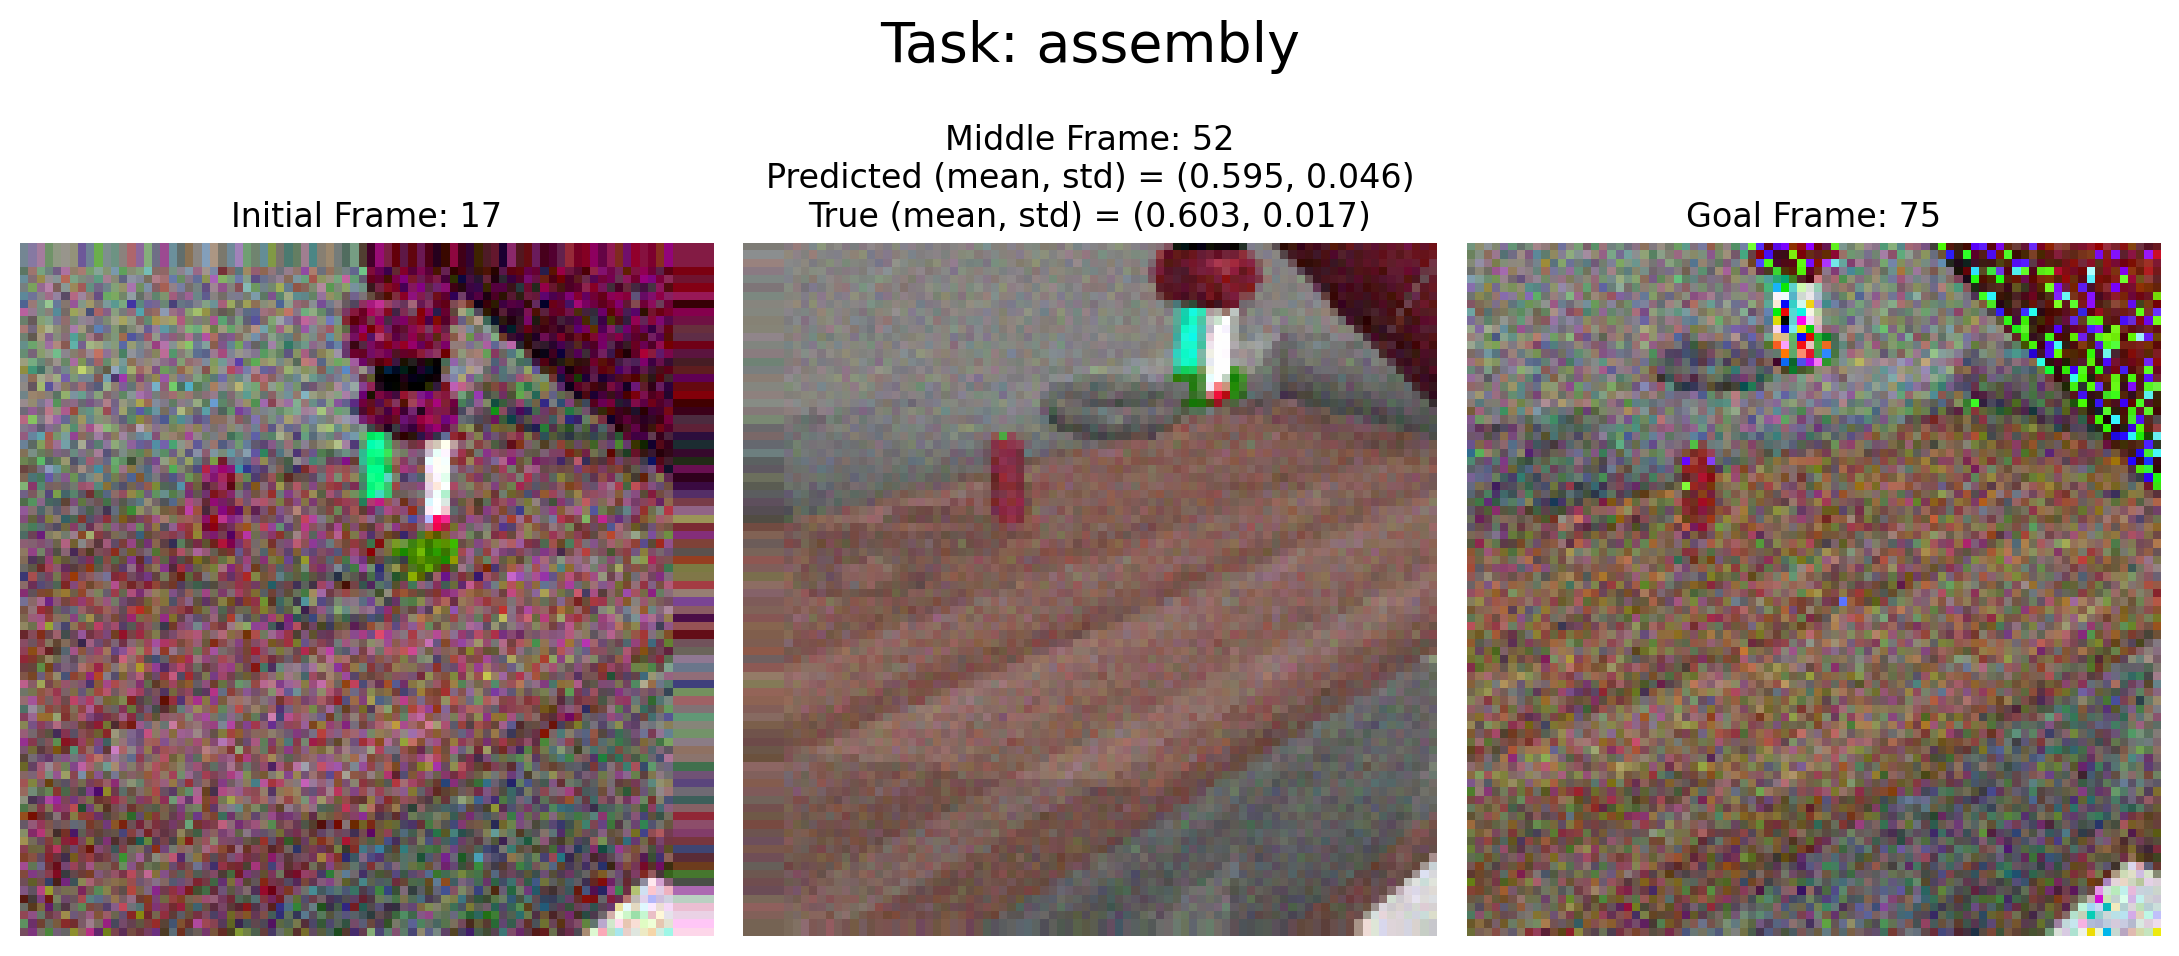

In [83]:
init = 17
mid = 52
goal = 75

pred_and_show(tasks[0], transform, init, mid, goal)
# plt.savefig(args.output_dir + 'example.png')

## Rank2Reward Dataset

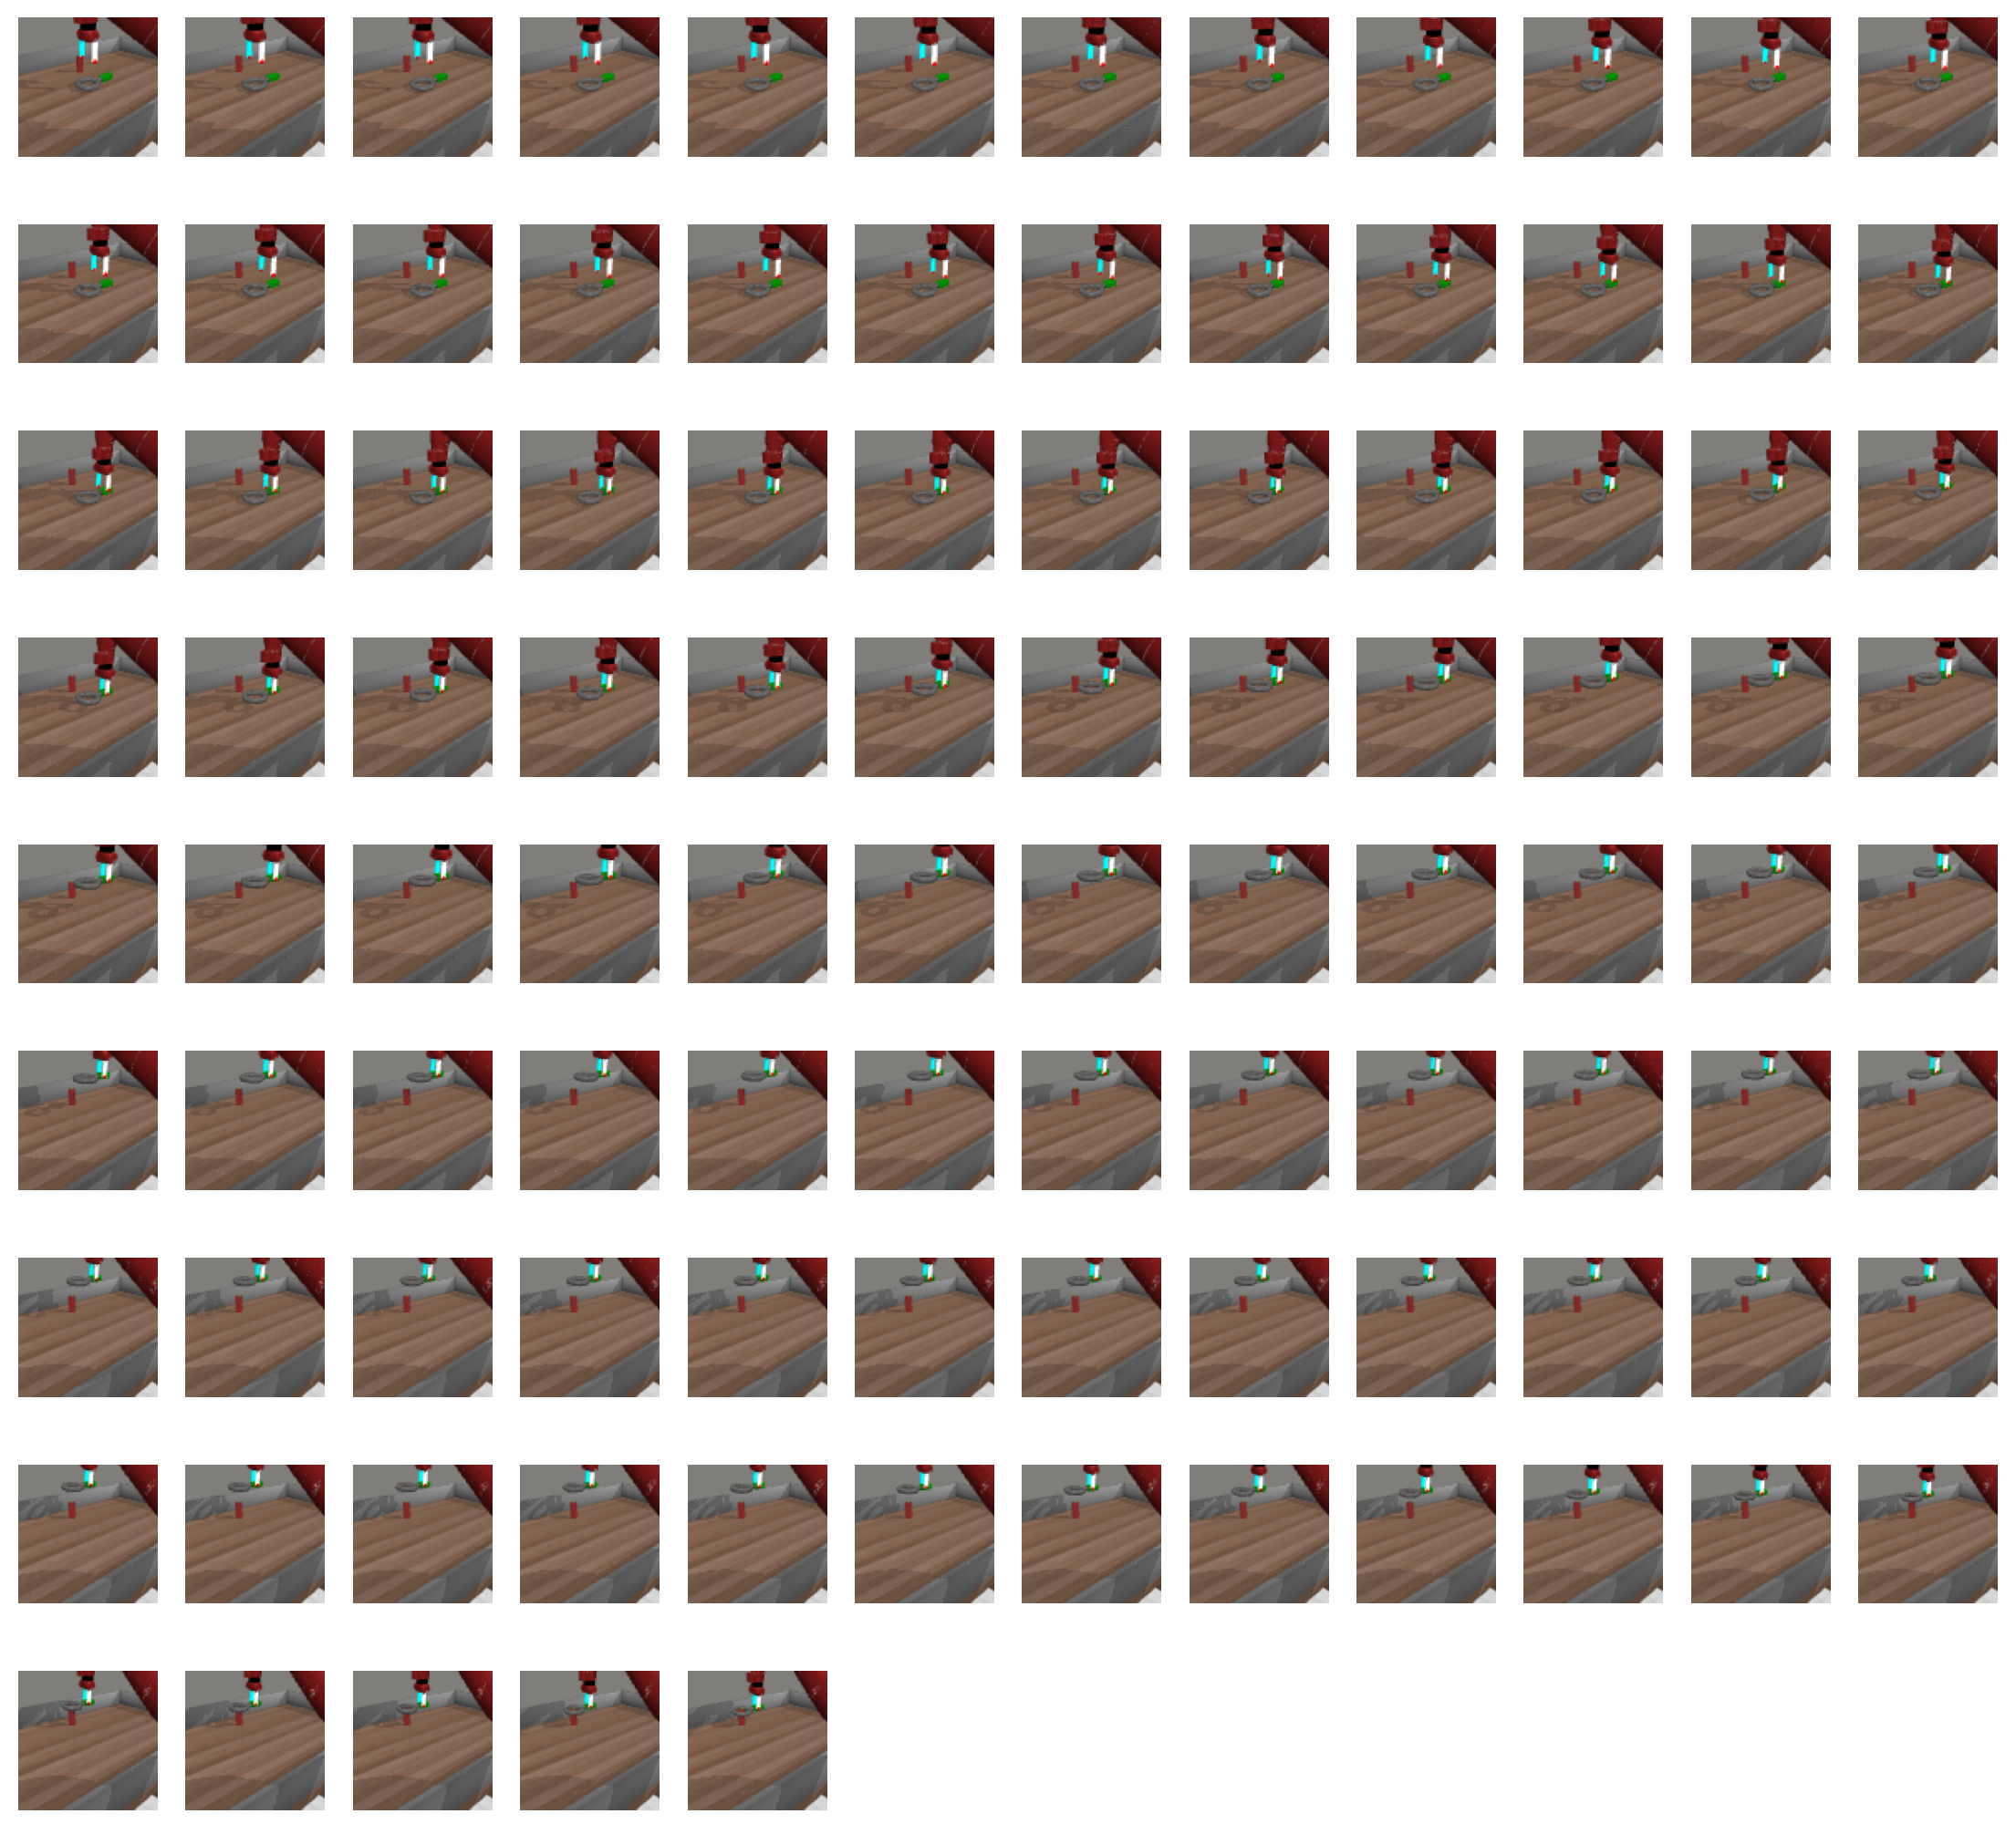

In [6]:
data_path1='/home/kevinwu/ripl/Video2Reward/data/rank2reward_original/'
with h5py.File(data_path1 + tasks[0] + '/expert_data.hdf', 'r') as file:
    dataset = file['/0']
    s_t = dataset['s_t'] # state
    a_t = dataset['a_t'] # action
    g_t = dataset['g_t'] # goal
    r_t = dataset['r_t'] # reward
    env_full_s_t = dataset['env_full_s_t'] # full state
    # print(env_full_s_t[0])
    
    # plot all states
    n_cols = 12
    n_rows = int(np.ceil(len(s_t) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 13))
    axes = axes.flatten()
    for i, s in enumerate(s_t):
        img = np.transpose(s, (1, 2, 0))
        axes[i].imshow(img)
    for ax in axes:
        ax.axis('off')
    plt.show()

## Data Transform

[Random shift augmentation](https://github.com/facebookresearch/drqv2/blob/main/drqv2.py#L242) (DrQ-v2)

[Color Jitter](https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html#torchvision.transforms.ColorJitter)

[Gaussian Blur](https://pytorch.org/vision/main/generated/torchvision.transforms.GaussianBlur.html#torchvision.transforms.GaussianBlur)

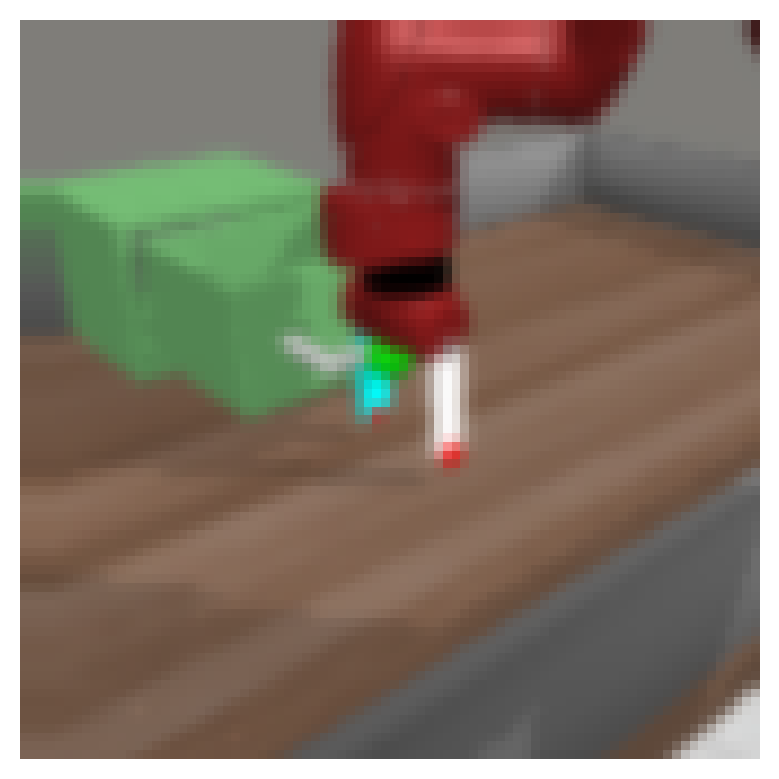

In [39]:
transform = transforms.Compose([
    transforms.ToTensor(),
    RandomApplyTransform([
        transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 1.0)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        GaussianNoise(mean=0, std=(0.01, 0.1)),
        RandomShiftsAug(pad=4)
    ]),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image = Image.open(os.path.join(data_path, tasks[1], 'train', '0', '100.png'))
x = transform(image)

plt.imshow(x.permute(1, 2, 0))
plt.axis('off')
plt.show()